In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import seaborn as sns

toPounds = 2.20462
toKgs = 1/toPounds

# import workout data
workout_history = pd.read_csv('data/strong.csv')

# data cleansing
# remove "Warmup sets" (first 2 sets)
workout_history.drop(workout_history[workout_history['Set Order'] < 3].index, inplace = True)
# shift "Working set" order (up 2 sets)
workout_history["Set Order"] = workout_history["Set Order"] - 2
# remove last set
workout_history.drop(workout_history[workout_history['Set Order'] >= 6].index, inplace = True)

In [2]:
print(workout_history)

                     Date Workout Name Duration  \
2     2022-10-16 00:16:36    Shoulders    28min   
3     2022-10-16 00:16:36    Shoulders    28min   
4     2022-10-16 00:16:36    Shoulders    28min   
5     2022-10-16 00:16:36    Shoulders    28min   
6     2022-10-16 00:16:36    Shoulders    28min   
...                   ...          ...      ...   
1148  2023-07-21 00:08:04    Shoulders    41min   
1149  2023-07-21 00:08:04    Shoulders    41min   
1150  2023-07-21 00:08:04    Shoulders    41min   
1151  2023-07-21 00:08:04    Shoulders    41min   
1152  2023-07-21 00:08:04    Shoulders    41min   

                        Exercise Name  Set Order  Weight  Reps  Distance  \
2     Seated Overhead Press (Barbell)          1    50.0    10         0   
3     Seated Overhead Press (Barbell)          2    50.0    10         0   
4     Seated Overhead Press (Barbell)          3    50.0     8         0   
5     Seated Overhead Press (Barbell)          4    45.0     8         0   
6     S

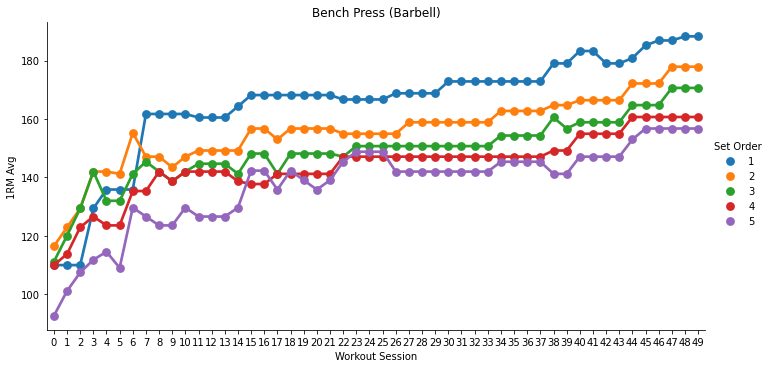

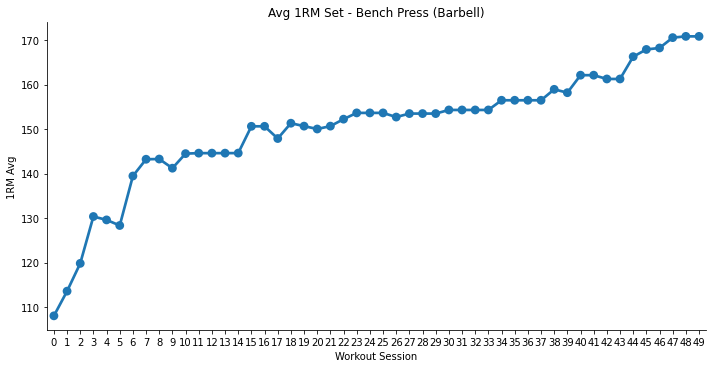

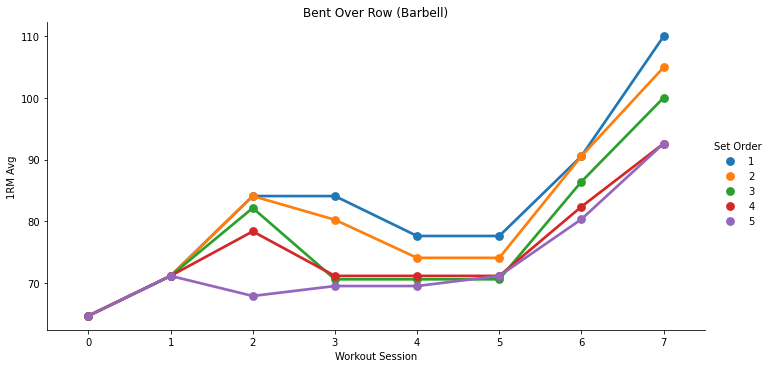

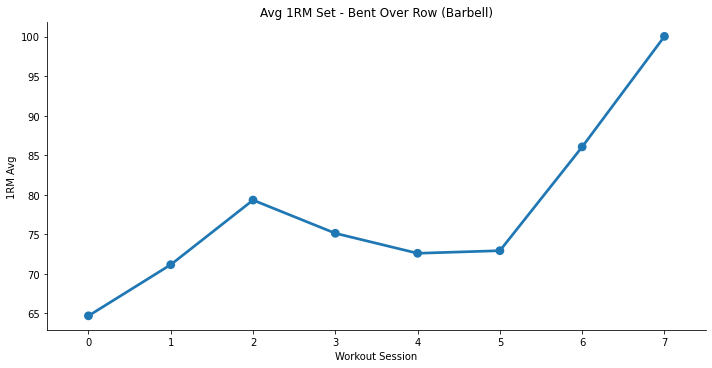

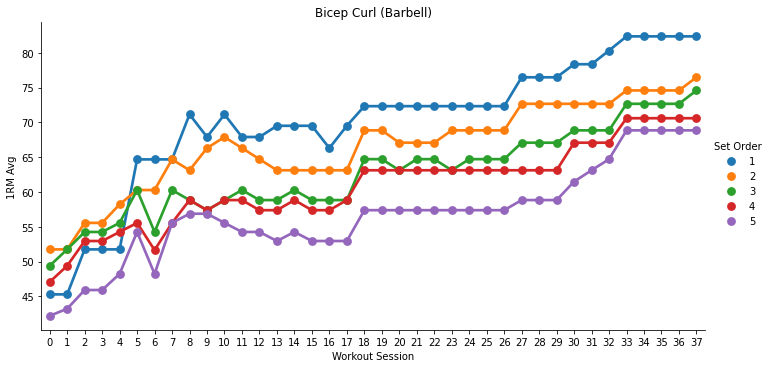

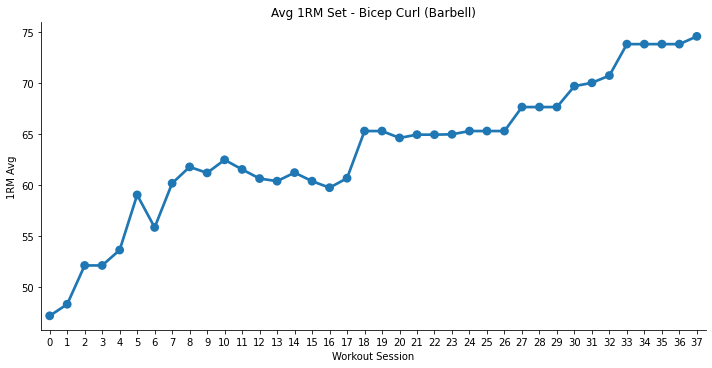

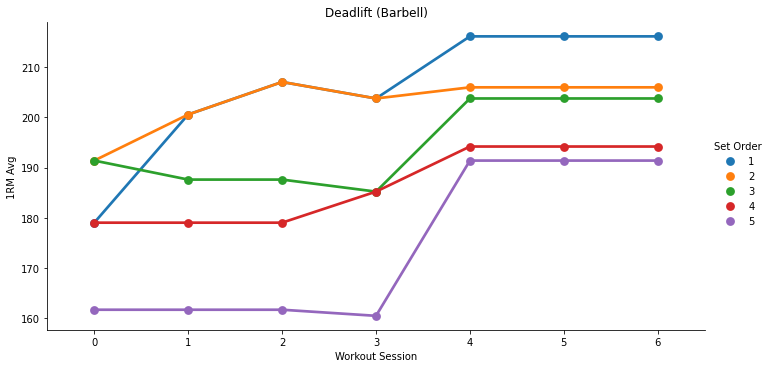

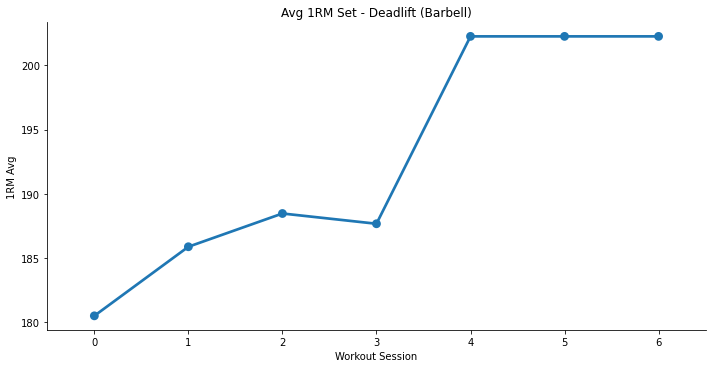

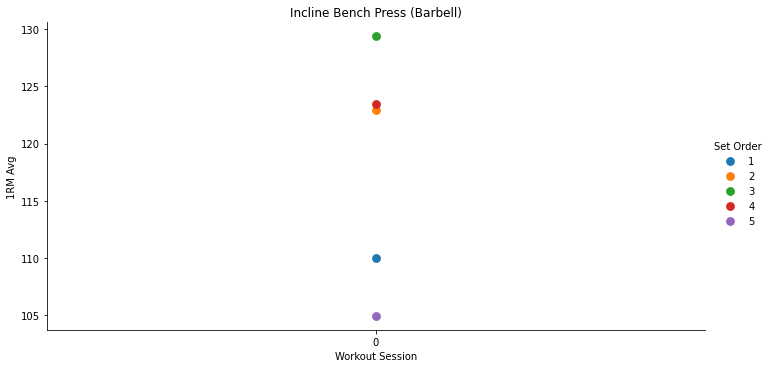

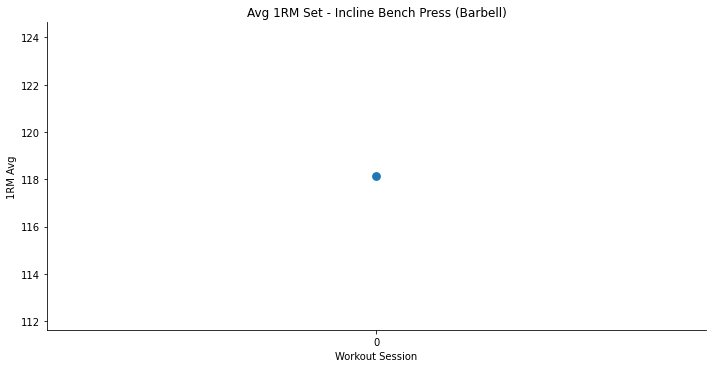

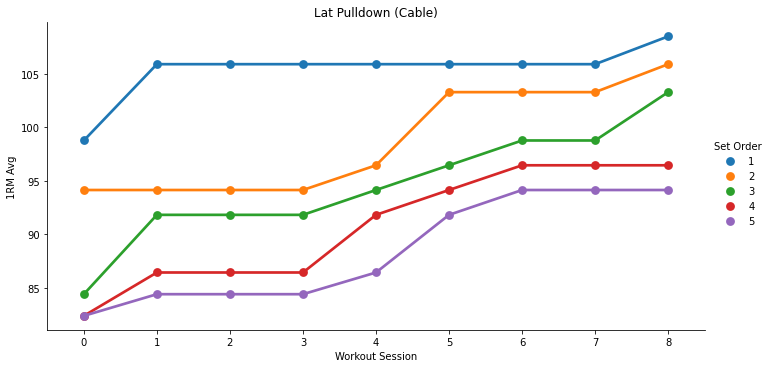

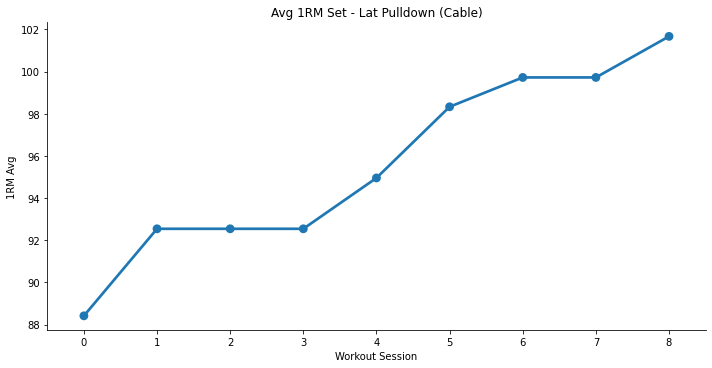

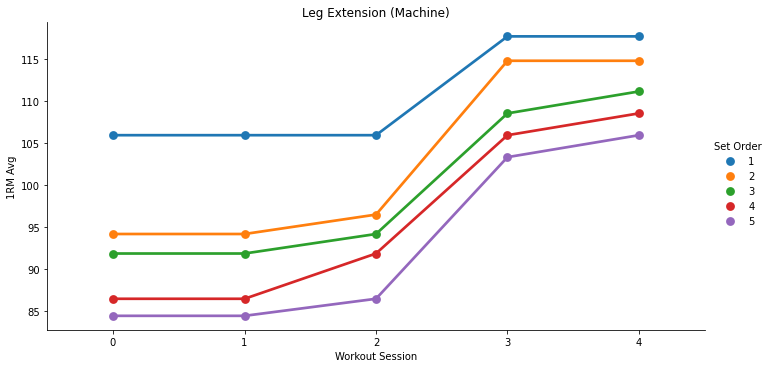

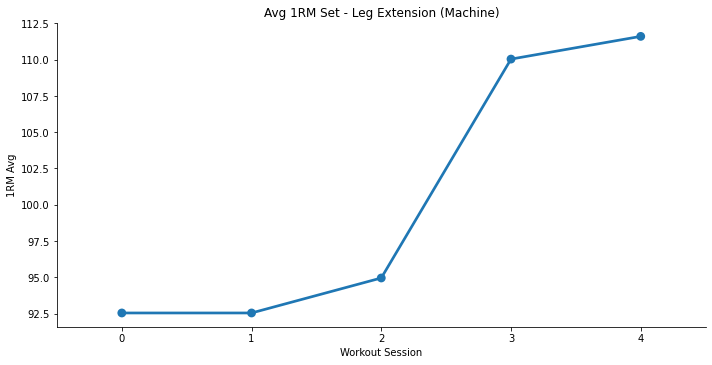

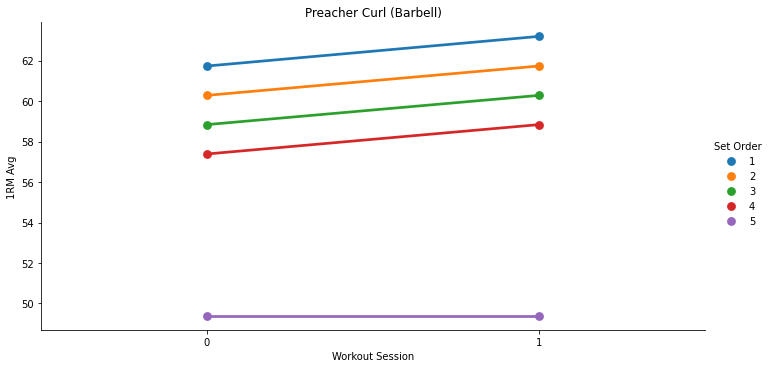

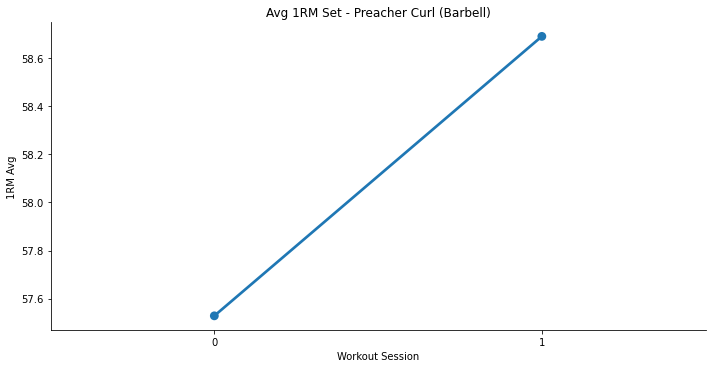

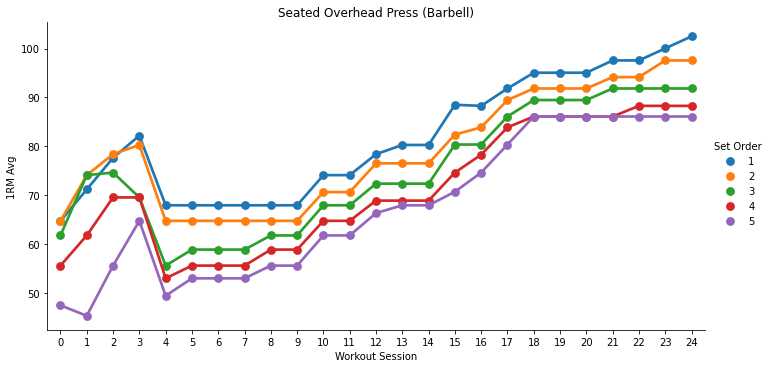

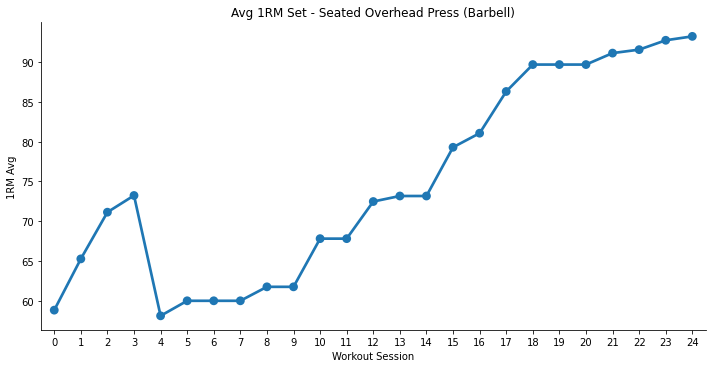

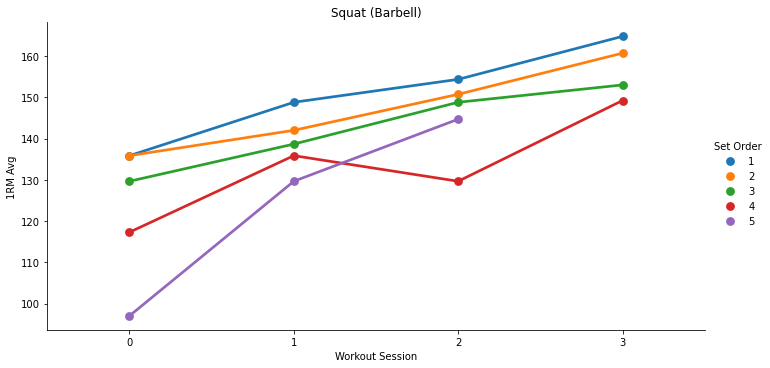

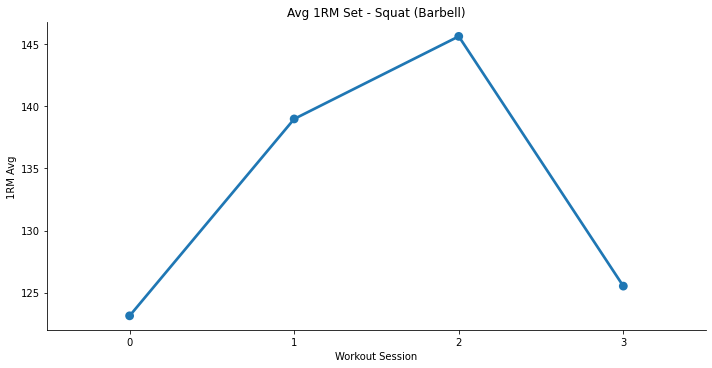

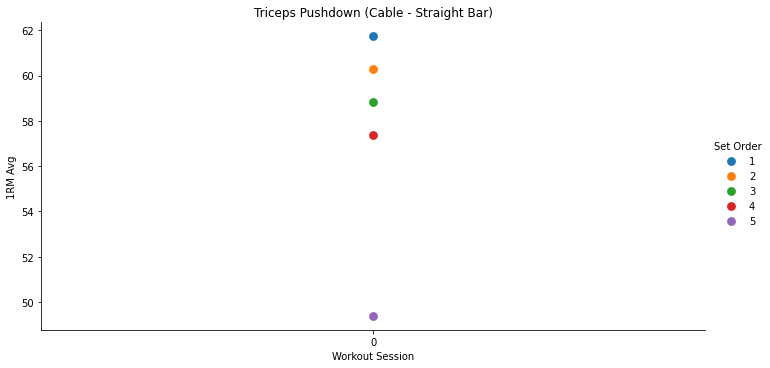

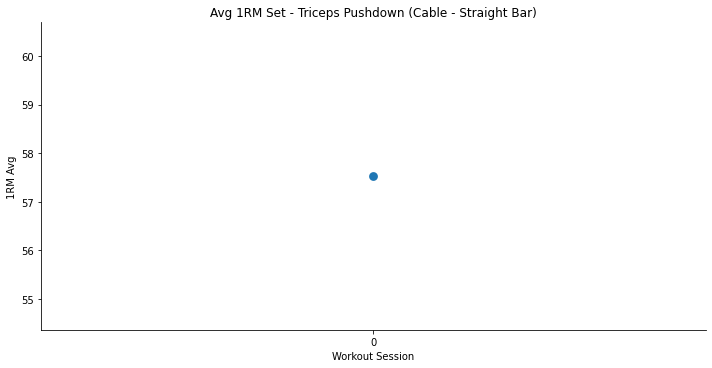

In [62]:
# create an Empty DataFrame object
mergedExercises = pd.DataFrame()

# get an array of unique Excercise Names
exercise_Names = np.unique(np.array(workout_history['Exercise Name']))

# loop through all the exercises in the dataframe
for exercise_Name in exercise_Names:
    # get all rows with that have the given exercise
    exercise = workout_history.loc[workout_history['Exercise Name'] == exercise_Name]

    dfs = dict(tuple(exercise.groupby('Set Order')))
    for x in dfs:
        # reset the index for each dataframe in the dictonary
        dfs[x] = dfs[x].reset_index()
        dfs[x] = dfs[x].reset_index()
        dfs[x] = dfs[x].rename(columns={'level_0': 'Workout Session'})
    
        # get 1RM's using different approximation methods. Then taking the avg of those methods
        dfs[x]["1RM Brzycki"] = ((dfs[x]["Weight"] * toKgs)  * (36 / (37 - dfs[x]["Reps"]))) * toPounds
        dfs[x]["1RM Epley"] = ((dfs[x]["Weight"] * toKgs)  * (1 + (0.0333 * dfs[x]["Reps"]))) * toPounds
        dfs[x]["1RM Lombardi"] = ((dfs[x]["Weight"] * toKgs)  * pow(dfs[x]["Reps"], 0.1)) * toPounds
        dfs[x]["1RM O’Conner"] = ((dfs[x]["Weight"] * toKgs)  * (1 + (0.025 * dfs[x]["Reps"]))) * toPounds
        dfs[x]["1RM Avg"] = (dfs[x]["1RM Brzycki"] + dfs[x]["1RM Epley"] + dfs[x]["1RM Lombardi"] + dfs[x]["1RM O’Conner"]) / 4
    
    # merge each sets dataframe into 1 dataframe for input in plotting
    mergedSets = pd.concat(dfs)
    # plot the exercise 1RM avgs per set
    sns.catplot(x='Workout Session', y='1RM Avg', hue='Set Order', data=mergedSets, kind='point', height=5, aspect=10/5)
    plt.title(exercise_Name)
    plt.show()
    
    # calculate avg of all sets in an exercise
    mergedAvgSet = mergedSets.groupby(['Workout Session'])['1RM Avg'].transform('sum') / len(dfs)
    # drop 'multi index' workout sessions
    mergedAvgSet = pd.DataFrame(mergedAvgSet).droplevel(0)
    # reset the index and rename
    mergedAvgSet = mergedAvgSet.reset_index().rename(columns={'index': 'Workout Session'})
    
    # merge each exercise dataframe into 1 dataframe for input in plotting
    mergedAvgSet['Exercise Name'] = exercise_Name
    mergedAvgSet['1RM Log'] = np.log(mergedAvgSet['1RM Avg']) - np.log(mergedAvgSet['1RM Avg'].shift(1))
    mergedAvgSet['1RM Diff'] = mergedAvgSet['1RM Avg'] - mergedAvgSet['1RM Avg'].shift(1)
    mergedExercises = pd.concat([mergedExercises, mergedAvgSet])
    
    # plot the avg exercise
    sns.catplot(x='Workout Session', y='1RM Avg', data=mergedAvgSet, kind='point', height=5, aspect=10/5)
    plt.title('Avg 1RM Set - ' + exercise_Name)
    plt.show()

    Workout Session     1RM Avg                            Exercise Name  \
0                 0  108.024484                    Bench Press (Barbell)   
1                 1  113.571253                    Bench Press (Barbell)   
2                 2  119.818533                    Bench Press (Barbell)   
3                 3  130.353993                    Bench Press (Barbell)   
4                 4  129.590133                    Bench Press (Barbell)   
..              ...         ...                                      ...   
0                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
1                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
2                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
3                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   
4                 0   57.528543  Triceps Pushdown (Cable - Straight Bar)   

     1RM Log   1RM Diff  
0        NaN        NaN  
1   0.050073   5.546769  
2   0.053

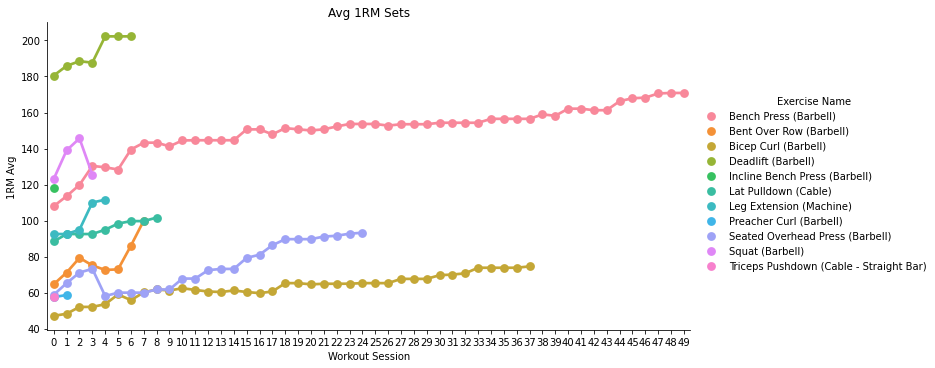

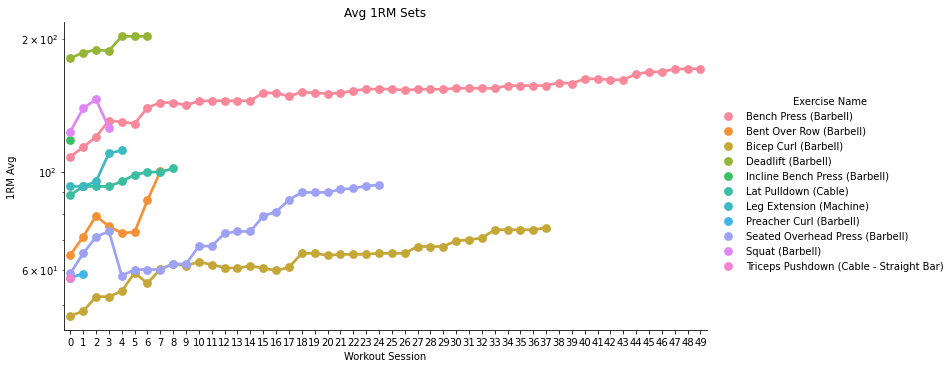

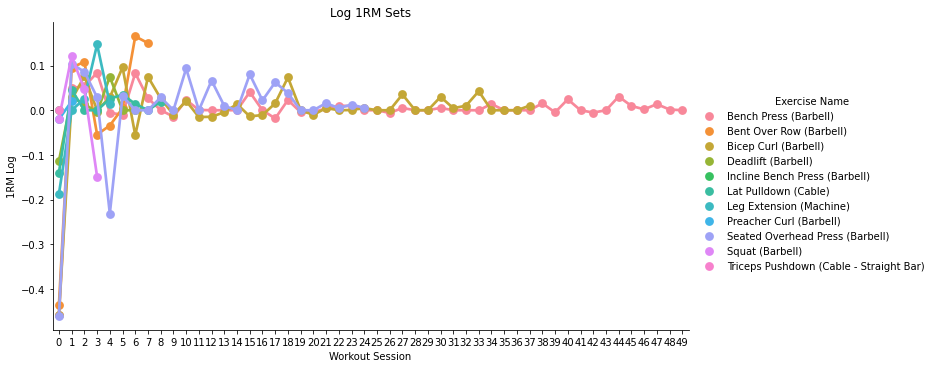

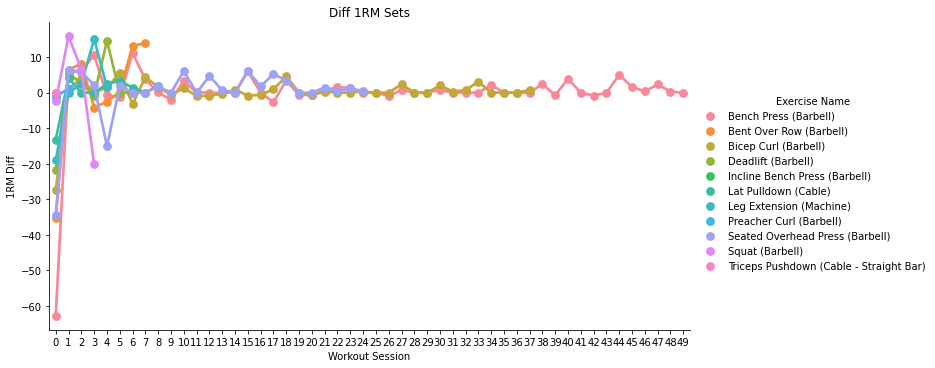

In [64]:
print(mergedExercises)

# plot the exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Avg', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Avg 1RM Sets')
plt.show()

# plot the LOG exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Avg', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Avg 1RM Sets')
plt.yscale('log')
plt.show()

# plot the LOG exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Log', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Log 1RM Sets')
#plt.yscale('log')
plt.show()

# plot the Diff exercises 1RM avgs
sns.catplot(x='Workout Session', y='1RM Diff', hue='Exercise Name', data=mergedExercises, kind='point', height=5, aspect=10/5)
plt.title('Diff 1RM Sets')
#plt.yscale('log')
plt.show()

In [54]:
#mergedExercises.groupby(['Exercise Name'])['1RM Avg']
df1 = mergedExercises[mergedExercises['Exercise Name'].str.match("Bench Press \(Barbell\)")].drop(columns=['Workout Session', 'Exercise Name'])
df2 = mergedExercises[mergedExercises['Exercise Name'].str.match("Bicep Curl \(Barbell\)")].drop(columns=['Workout Session', 'Exercise Name'])
# .diff().corr()
#df1.diff()
df1.diff().corrwith(df2.diff(), axis = 0)

1RM Avg    0.007904
dtype: float64

In [49]:
print(df1.diff())
print(df2.diff())

       1RM Avg
0          NaN
1     5.546769
2     6.247280
3    10.535459
4    -0.763859
..         ...
245   1.621424
246   0.335656
247   2.324610
248   0.280988
249   0.000000

[250 rows x 1 columns]
      1RM Avg
0         NaN
1    1.138891
2    3.809662
3    0.000000
4    1.516449
..        ...
185  3.086254
186  0.000000
187  0.000000
188  0.000000
189  0.762171

[190 rows x 1 columns]
